In [20]:
from binance.client import Client as bnb_client
import math
from datetime import datetime
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
#client = bnb_client()
###  if you're in the US, use: 
client = bnb_client(tld='US')#" here instead

def get_binance_px(symbol,freq,start_ts = '2025-3-9',end_ts='2025-10-22'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','NEARUSDT','ATOMUSDT','HBARUSDT','ETHUSDT','ADAUSDT','LINKUSDT','SUIUSDT','XLMUSDT','BNBUSDT','ICPUSDT','UNIUSDT','LTCUSDT','AAVEUSDT','XRPUSDT','AVAXUSDT','ETCUSDT','DOTUSDT']
freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

C:\Users\ephet\AppData\Local\Temp\ipykernel_39348\3656325402.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
C:\Users\ephet\AppData\Local\Temp\ipykernel_39348\3656325402.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))


In [2]:
import statsmodels.api as sm

In [3]:
def drawdown_durations(series):
    """
    Calculate durations of drawdown periods in a price or cumulative return series.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - durations: list of drawdown durations (in number of periods)
    - max_duration: longest drawdown duration
    """
    running_max = series.cummax()
    in_drawdown = series < running_max

    durations = []
    current_duration = 0

    for drawdown in in_drawdown:
        if drawdown:
            current_duration += 1
        elif current_duration > 0:
            durations.append(current_duration)
            current_duration = 0

    # Catch trailing drawdown
    if current_duration > 0:
        durations.append(current_duration)

    return durations, max(durations) if durations else 0


In [4]:
def max_drawdown(x):
    """
    Compute max drawdown for a Series or each column in a DataFrame.
    
    Parameters:
    - x: pd.Series or pd.DataFrame of cumulative returns or prices
    
    Returns:
    - float (for Series) or pd.Series (for DataFrame)
    """
    def compute_dd(series):
        running_max = series.cummax()
        drawdown = series - running_max
        return drawdown.min()
    
    if isinstance(x, pd.Series):
        return compute_dd(x)
    elif isinstance(x, pd.DataFrame):
        return x.apply(compute_dd)
    else:
        raise TypeError("Input must be a pandas Series or DataFrame")


In [5]:
def percent_time_in_drawdown(series):
    """
    Calculate the percentage of time the series is in drawdown.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - float: percentage of time in drawdown
    """
    running_max = series.cummax()
    in_drawdown = series < running_max
    percent = in_drawdown.sum() / len(series) * 100
    return percent

In [6]:
train=ret.head(len(ret)//2)
test=ret.tail(len(ret)//2)

In [7]:
ret

,BTCUSDT,NEARUSDT,ATOMUSDT,HBARUSDT,ETHUSDT,ADAUSDT,LINKUSDT,SUIUSDT,XLMUSDT,BNBUSDT,ICPUSDT,UNIUSDT,LTCUSDT,AAVEUSDT,XRPUSDT,AVAXUSDT,ETCUSDT,DOTUSDT
2025-03-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-09 04:00:00,-0.002664,-0.004224,-0.006123,-0.003556,-0.001244,0.013335,-0.006549,0.010553,0.011619,-0.005504,-0.008503,0.001418,-0.000394,0.009213,0.004779,-0.003941,-0.005517,-0.000232
2025-03-09 08:00:00,-0.009543,-0.024744,-0.013307,-0.040236,-0.018567,-0.040093,-0.031641,-0.032921,-0.029792,-0.012127,-0.011149,-0.024773,-0.017153,-0.035807,-0.033122,-0.024233,-0.010590,-0.024571
2025-03-09 12:00:00,-0.023761,-0.020660,-0.018981,-0.027189,-0.022790,-0.031775,-0.023826,-0.026871,-0.012209,-0.020126,-0.021683,-0.021338,0.004112,0.000947,-0.031465,-0.030411,-0.024975,-0.015209
2025-03-09 16:00:00,-0.006561,-0.045152,-0.025458,-0.029908,-0.026005,-0.032156,-0.023710,-0.009233,0.006742,-0.010199,-0.024113,-0.038713,-0.029168,-0.045930,-0.010204,-0.042342,-0.052797,-0.019305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-16 08:00:00,-0.004182,-0.003370,-0.002466,0.004593,-0.001251,0.006705,0.005117,0.012336,0.020844,-0.003534,0.010549,0.014181,-0.004432,0.015035,0.005881,-0.006530,0.004912,0.008619
2025-09-16 12:00:00,0.002469,0.019910,0.013708,0.000508,-0.008476,-0.001723,-0.009334,0.006260,-0.001551,0.009465,0.000000,-0.013768,0.003492,-0.017091,0.002015,-0.014459,-0.014663,0.002611
2025-09-16 16:00:00,0.007723,0.004788,0.015961,0.006305,0.003151,0.005867,0.005996,0.005722,-0.002071,0.018475,0.016191,0.012542,-0.000087,0.023253,0.003692,0.000333,0.011409,0.013494
2025-09-16 20:00:00,0.001425,-0.001100,-0.002182,-0.000841,0.005559,0.006519,0.000000,-0.003894,0.001038,0.002370,-0.007547,-0.005386,-0.001566,-0.000900,-0.002200,0.001000,0.003433,0.002102


<Axes: >

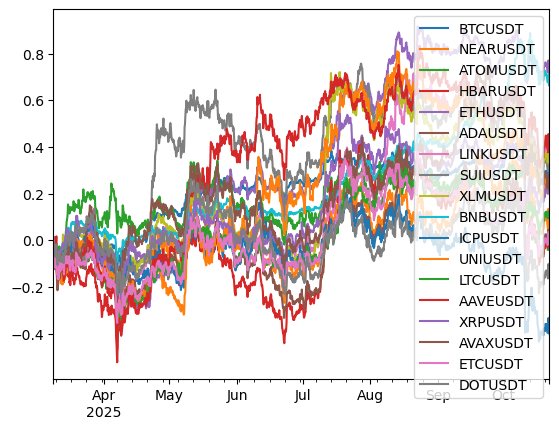

In [21]:
ret.iloc[:, :].cumsum().plot() #BTC

                      BTCUSDT  NEARUSDT  ATOMUSDT  HBARUSDT   ETHUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 04:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 08:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 12:00:00 -0.062713 -0.028536 -0.051238 -0.028037 -0.023297   
2025-03-09 16:00:00 -0.006173  0.020282  0.108466 -0.074074 -0.021164   
...                       ...       ...       ...       ...       ...   
2025-10-21 08:00:00 -0.062693  0.065789 -0.020898 -0.025026 -0.042570   
2025-10-21 12:00:00 -0.069081  0.065381 -0.037920  0.060259 -0.019991   
2025-10-21 16:00:00  0.045142 -0.125161 -0.045241  0.031340  0.010414   
2025-10-21 20:00:00  0.056350  0.056350  0.041339  0.026328  0.034906   
2025-10-22 00:00:00 -0.068754 -0.057200  0.021753 -0.030240 -0.053990   

                      ADAUSDT  LINKUSDT   SUIUSDT   XLMUSDT   BNBUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN 

<Axes: >

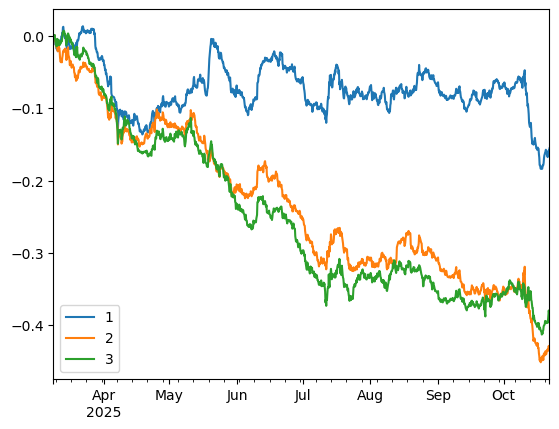

In [22]:
#RETURN STRATEGY
strats_lag4 = {}  # For comparing Sharpe values across horizons
n=252
for hor in [1,2,3]:
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(pct=True)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    strat = (avg_ret.shift(2)* ret).sum(axis=1) #Momentum Strategy
    print(avg_ret.shift(2))
    strats_lag4[hor] = strat

    # Build regression inputs
    X = sm.add_constant(ret.iloc[:, :])  # Benchmark BTC with intercept 
    df = pd.concat([strat, X], axis=1)
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Re-split cleaned data
    y_clean = df_clean.iloc[:, 0]  # Strategy returns
    X_clean = df_clean.iloc[:, 1:]  # Benchmark + intercept

    # Run regression
    model = sm.OLS(y_clean, X_clean).fit()
    alpha_t_stat = model.tvalues['const']
    alpha = model.params['const']

    print(f"Horizon {hor}: alpha = {alpha:.6f}, t-stat = {alpha_t_stat:.3f}")

strats_lag4 = pd.DataFrame(strats_lag4)
to = (strats_lag4.fillna(0) - strats_lag4.shift().fillna(0)).abs()
 #ret will be replaced with whatever strategy we are using
tcost_bps = 20 # (comissions + slip)
T_cost_tot=pd.DataFrame(to*tcost_bps*1e-4)
net_ret=strats_lag4-T_cost_tot
print(net_ret.mean()*np.sqrt(n*6)/net_ret.std()) # first signal spotted, a reversal)
print(((net_ret.mean()*np.sqrt(n*6))))
print(net_ret.corr())
net_ret.cumsum().plot() 

In [23]:
net_ret

,1,2,3
2025-03-09 00:00:00,0.000000,0.000000,0.000000
2025-03-09 04:00:00,0.000000,0.000000,0.000000
2025-03-09 08:00:00,0.000000,0.000000,0.000000
2025-03-09 12:00:00,0.000966,0.001080,0.001305
2025-03-09 16:00:00,-0.006355,-0.004428,-0.004221
...,...,...,...
2025-10-21 08:00:00,0.005060,0.000937,0.003889
2025-10-21 12:00:00,0.001574,0.001878,0.006820
2025-10-21 16:00:00,0.002620,0.003700,0.006440
2025-10-21 20:00:00,-0.003731,-0.005192,-0.003989


-3.197138723950986
0.9893985557185419
Drawdown durations: [1359]
Longest drawdown: 226.5 days
Percentage of time in drawdown: 99.71%


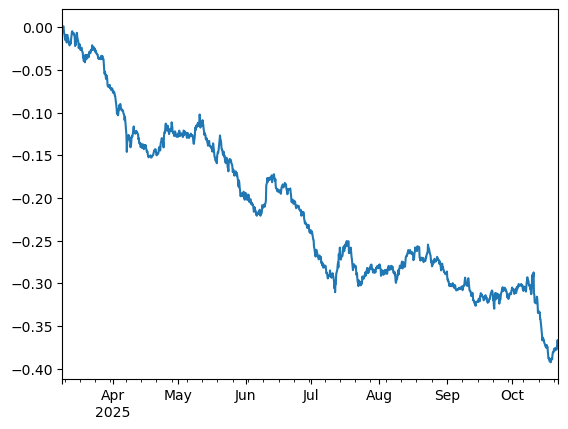

In [24]:
n=252
SR1=net_ret[1]
SR1=SR1.mean()*np.sqrt(n*6)/SR1.std()
SR2=net_ret[2]
SR2=SR2.mean()*np.sqrt(n*6)/SR2.std()
SR3=net_ret[3]
SR3=SR3.mean()*np.sqrt(n*6)/SR3.std()
tot=SR1+SR2+SR3
w1=SR1/tot
w2=SR2/tot
w3=SR3/tot
combo_1 = w1*net_ret[1]+w2*net_ret[2]+w3*net_ret[3]
print(combo_1.mean()*np.sqrt(n*6)/combo_1.std())
print((combo_1.mean()*np.sqrt(n*6)+1)) #approximate yearly return))
combo_1.cumsum().plot()
max_drawdown(combo_1)
durations, max_dd_time = drawdown_durations(combo_1.cumsum())
print(f"Drawdown durations: {durations}")
print(f"Longest drawdown: {max_dd_time/6} days")
pct_drawdown = percent_time_in_drawdown(combo_1.cumsum())
print(f"Percentage of time in drawdown: {pct_drawdown:.2f}%")

                      BTCUSDT  NEARUSDT  ATOMUSDT  HBARUSDT   ETHUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 04:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 08:00:00  0.062713  0.028536  0.051238  0.028037  0.023297   
2025-03-09 12:00:00  0.006173 -0.020282 -0.108466  0.074074  0.021164   
2025-03-09 16:00:00  0.065789 -0.000726  0.020036  0.041567  0.046565   
...                       ...       ...       ...       ...       ...   
2025-10-21 08:00:00  0.069081 -0.065381  0.037920 -0.060259  0.019991   
2025-10-21 12:00:00 -0.045142  0.125161  0.045241 -0.031340 -0.010414   
2025-10-21 16:00:00 -0.056350 -0.056350 -0.041339 -0.026328 -0.034906   
2025-10-21 20:00:00  0.068754  0.057200 -0.021753  0.030240  0.053990   
2025-10-22 00:00:00  0.080099 -0.183732 -0.001652 -0.005367  0.028076   

                      ADAUSDT  LINKUSDT   SUIUSDT   XLMUSDT   BNBUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN 

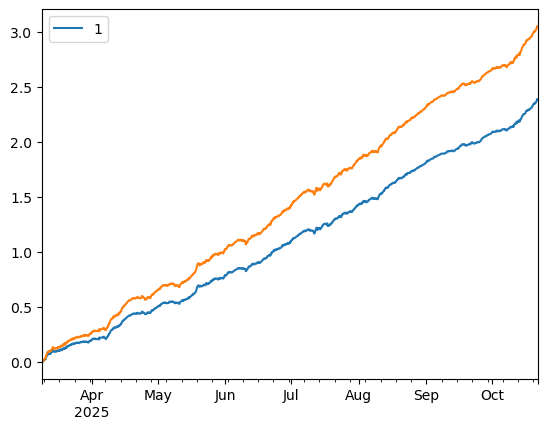

In [25]:
#RETURN STRATEGY 2
strats_lag2 = {}  # For comparing Sharpe values across horizons
n=252
for hor in [1]:
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(pct=True)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    strat = (-avg_ret.shift()* ret).sum(axis=1) #Reversal Strategy
    print(-avg_ret.shift())
    strats_lag2[hor] = strat

    # Build regression inputs
    X = sm.add_constant(ret.iloc[:, 0])  # Benchmark BTC with intercept 
    df = pd.concat([strat, X], axis=1)
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Re-split cleaned data
    y_clean = df_clean.iloc[:, 0]  # Strategy returns
    X_clean = df_clean.iloc[:, 1:]  # Benchmark + intercept

    # Run regression
    model = sm.OLS(y_clean, X_clean).fit()
    alpha_t_stat = model.tvalues['const']
    alpha = model.params['const']

    print(f"Horizon {hor}: alpha = {alpha:.6f}, t-stat = {alpha_t_stat:.3f}")

strats_lag2 = pd.DataFrame(strats_lag2)
to = (strats_lag2.fillna(0) - strats_lag2.shift().fillna(0)).abs()
 #ret will be replaced with whatever strategy we are using
tcost_bps = 20 # (comissions + slip)
T_cost_tot=pd.DataFrame(to*tcost_bps*1e-4)
net_ret=strats_lag2-T_cost_tot
print(net_ret.mean()*np.sqrt(n*6)/net_ret.std()) # first signal spotted, a reversal) SR
print(((net_ret.mean()*np.sqrt(n*6)+1)))
print((net_ret.mean()*np.sqrt(6)+1)**(252/12))
print(net_ret.corr())
net_ret.cumsum().plot() 

n=252
SR1=net_ret[1].mean()*np.sqrt(n*6)/net_ret[1].std()
SR2=combo_1.mean()*np.sqrt(n*6)/combo_1.std()
tot=SR1+SR2
w1=SR1/tot
w2=SR2/tot
combo_2=w1*net_ret[1]+w2*combo_1
print(w1)
print(w2)
print((combo_2.mean()*np.sqrt(n*6)/combo_2.std()))
print(12*(((combo_2.mean()*np.sqrt(6)+1))**(252/12)-1))
print(combo_2.mean()*np.sqrt(n*6))
max_drawdown(combo_2)
durations, max_dd_time = drawdown_durations(combo_2.cumsum())
print(f"Drawdown durations: {durations}")
print(f"Longest drawdown: {max_dd_time/6} days")
pct_drawdown = percent_time_in_drawdown(combo_2.cumsum())
print(f"Percentage of time in drawdown: {pct_drawdown:.2f}%")
y=combo_2.cumsum().plot()


                      BTCUSDT  NEARUSDT  ATOMUSDT  HBARUSDT   ETHUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 04:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 08:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 12:00:00 -0.026334 -0.034047 -0.106379  0.063924  0.014314   
2025-03-09 16:00:00  0.117822 -0.076831 -0.047853  0.013501 -0.047653   
...                       ...       ...       ...       ...       ...   
2025-10-21 08:00:00 -0.013070 -0.103631 -0.121677  0.022018 -0.013738   
2025-10-21 12:00:00  0.064013 -0.090981 -0.014774 -0.018346  0.009835   
2025-10-21 16:00:00  0.064148  0.067829  0.047587  0.004345  0.041147   
2025-10-21 20:00:00  0.046002  0.045509  0.033202  0.024341  0.039110   
2025-10-22 00:00:00  0.066585 -0.221269 -0.000136  0.000136  0.028186   

                      ADAUSDT  LINKUSDT   SUIUSDT   XLMUSDT   BNBUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN 

<Axes: >

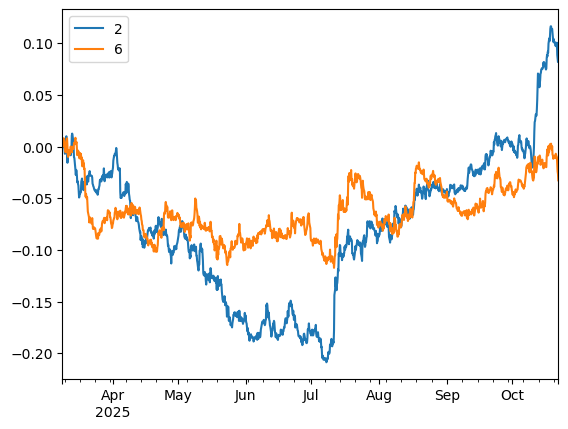

In [26]:
#VOL STRATEGY
n=252
strats_lag1 = {}#Use this for comparing sharpe values of time horizons
for hor in [2,6]:
    avg_ret = ret.rolling(hor,min_periods=1).std().rank(pct=True) #you can change the metric here, for instance vol instead of mean
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag1[hor] = (avg_ret.shift()*ret).sum(1) #Momentum
    print(avg_ret.shift())
strats_lag1 = pd.DataFrame(strats_lag1)
to = (strats_lag1.fillna(0) - strats_lag1.shift().fillna(0)).abs()
 #ret will be replaced with whatever strategy we are using
tcost_bps = 20 # (comissions + slip)
T_cost_tot=pd.DataFrame(to*tcost_bps*1e-4)
strats_lag1=strats_lag1-T_cost_tot
print(strats_lag1.mean()*np.sqrt(n*6)/strats_lag1.std()) # first signal spotted, a reversal)
print(strats_lag1.corr())
strats_lag1.cumsum().plot()

0.964133460350749 0.03586653964925097
17.04370632908856
0.0839953145406652
Drawdown durations: [1, 1, 1, 3, 1, 15, 2, 1, 3, 1, 2, 2, 3, 1, 1, 5, 1, 5, 2, 1, 1, 2, 6, 7, 2, 1, 3, 12, 8, 1, 9, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 10, 25, 2, 1, 1, 1, 1, 3, 1, 11, 6, 24, 1, 2, 2, 2, 2, 1, 1, 12, 3, 5, 2, 1, 1, 1, 1, 1, 7, 1, 2, 8, 2, 2, 2, 5, 6, 21, 2, 1, 1, 2, 3, 1, 7, 4, 2, 4, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 19, 13, 7, 10, 1, 1, 1, 5, 1, 4, 5, 7, 1, 1, 2, 4, 2, 13, 1, 16, 2, 1, 1, 4, 1, 4, 3, 4, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 6, 1, 1, 3, 7, 2, 1, 1, 16, 2, 13, 3, 1, 1, 1, 1, 1, 7, 1, 10, 3, 11, 7, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]
Longest drawdown: 4.166666666666667 days
Percentage of time in drawdown: 47.32%


<Axes: >

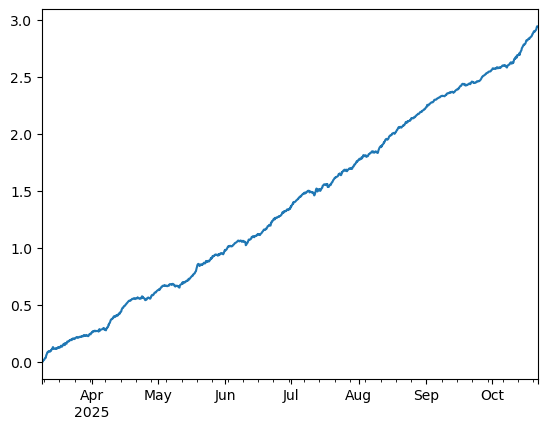

In [27]:
n=252
combo_3=strats_lag1[2]
SR1 = combo_2.mean()*np.sqrt(252*6)/combo_2.std()
SR2 = combo_3.mean()*np.sqrt(252*6)/combo_3.std()
tot=SR1+SR2
w1=SR1/tot
w2=SR2/tot
print(w1,w2)
combo_3=w1*combo_2+w2*combo_3 #long 8 hour rolling average vol and short 24 hour rolling average VOL lagged 16 hours
print(combo_3.mean()*np.sqrt(252*6)/combo_3.std()) # first signal spotted, a reversal)
print(combo_3.mean()*np.sqrt(252*6))
max_drawdown(combo_3)
durations, max_dd_time = drawdown_durations(combo_3.cumsum())
print(f"Drawdown durations: {durations}")
print(f"Longest drawdown: {max_dd_time/6} days")
pct_drawdown = percent_time_in_drawdown(combo_3.cumsum())
print(f"Percentage of time in drawdown: {pct_drawdown:.2f}%")
combo_3.cumsum().plot()


                      BTCUSDT  NEARUSDT  ATOMUSDT  HBARUSDT   ETHUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 04:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 08:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 12:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 16:00:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2025-10-21 08:00:00 -0.042298 -0.078811  0.057662 -0.016959 -0.008779   
2025-10-21 12:00:00  0.007395 -0.144389  0.074536  0.031290  0.028597   
2025-10-21 16:00:00 -0.023948 -0.136029  0.044697  0.073395 -0.010568   
2025-10-21 20:00:00 -0.005279 -0.087582  0.058689  0.011807  0.041186   
2025-10-22 00:00:00 -0.055672 -0.075326 -0.049495 -0.028717 -0.041071   

                      ADAUSDT  LINKUSDT   SUIUSDT   XLMUSDT   BNBUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN 

<Axes: >

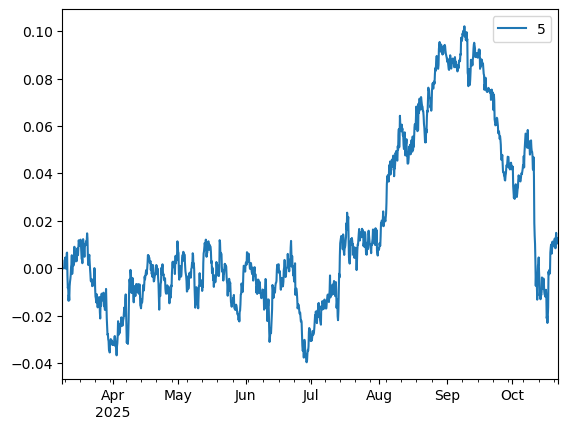

In [28]:
#SKEW STRATEGY
strats_lag2 = {}#Use this for comparing sharpe values of time horizons
for hor in [5]:
    avg_ret = ret.rolling(hor,min_periods=1).skew().rank(pct=True) #you can change the metric here, for instance vol instead of mean
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag2[hor] = (-avg_ret.shift(3)*ret).sum(1) #Reversal
    print(-avg_ret.shift(3))
strats_lag2 = pd.DataFrame(strats_lag2)
to = (strats_lag2.fillna(0) - strats_lag2.shift().fillna(0)).abs()
 #ret will be replaced with whatever strategy we are using
tcost_bps = 20 # (comissions + slip)
T_cost_tot=pd.DataFrame(to*tcost_bps*1e-4)
strats_lag2=strats_lag2-T_cost_tot
print(strats_lag2.mean()*np.sqrt(252*6)/strats_lag2.std()) # first signal spotted, a reversal)
print(strats_lag2.corr())
strats_lag2.cumsum().plot()

0.006065881105794905 0.9939341188942051
17.04535637612259
0.08348779469585545
Drawdown durations: [1, 1, 1, 3, 1, 15, 2, 1, 3, 1, 2, 2, 3, 1, 1, 5, 1, 5, 2, 1, 1, 2, 6, 7, 2, 1, 3, 12, 8, 1, 9, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 10, 25, 2, 1, 1, 1, 3, 1, 11, 6, 24, 1, 2, 2, 2, 2, 1, 1, 12, 3, 5, 2, 1, 1, 1, 1, 1, 7, 1, 2, 8, 2, 2, 2, 5, 6, 21, 2, 1, 1, 2, 3, 1, 7, 4, 2, 4, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 19, 13, 7, 10, 1, 1, 1, 5, 1, 4, 5, 7, 1, 1, 2, 4, 2, 13, 1, 16, 2, 1, 1, 4, 1, 4, 3, 4, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 6, 1, 1, 3, 7, 2, 1, 1, 16, 2, 13, 3, 1, 1, 1, 1, 1, 7, 1, 10, 3, 11, 7, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]
Longest drawdown: 4.166666666666667 days
Percentage of time in drawdown: 47.25%


<Axes: >

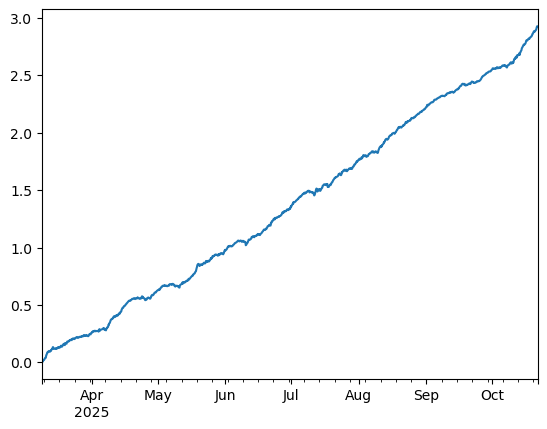

In [29]:
n=252
combo_4 = strats_lag2[5]
SR1 = combo_4.mean()*np.sqrt(252*6)/combo_4.std()
SR2 = combo_3.mean()*np.sqrt(252*6)/combo_3.std()
tot = SR1+SR2
w1 =  SR1/tot
w2 = SR2/tot
print(w1,w2)
combo_4 = w1*combo_4+w2*combo_3 #long 8 hour rolling average vol and short 24 hour rolling average VOL lagged 16 hours
print(combo_4.mean()*np.sqrt(252*6)/combo_4.std()) # first signal spotted, a reversal)
print(combo_4.mean()*np.sqrt(252*6))
max_drawdown(combo_4)
durations, max_dd_time = drawdown_durations(combo_4.cumsum())
print(f"Drawdown durations: {durations}")
print(f"Longest drawdown: {max_dd_time/6} days")
pct_drawdown = percent_time_in_drawdown(combo_4.cumsum())
print(f"Percentage of time in drawdown: {pct_drawdown:.2f}%")
combo_4.cumsum().plot()

                      BTCUSDT  NEARUSDT  ATOMUSDT  HBARUSDT   ETHUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 04:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 08:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 12:00:00       NaN       NaN       NaN       NaN       NaN   
2025-03-09 16:00:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2025-10-21 08:00:00  0.005416  0.090114  0.063058  0.043501  0.002034   
2025-10-21 12:00:00 -0.005475  0.095421  0.084712  0.036021  0.011257   
2025-10-21 16:00:00  0.078916 -0.024434  0.086261 -0.035101  0.060555   
2025-10-21 20:00:00 -0.033225 -0.088458 -0.078642  0.025232 -0.015937   
2025-10-22 00:00:00  0.017101 -0.117424  0.094474 -0.012478 -0.050078   

                      ADAUSDT  LINKUSDT   SUIUSDT   XLMUSDT   BNBUSDT  \
2025-03-09 00:00:00       NaN       NaN       NaN 

<Axes: >

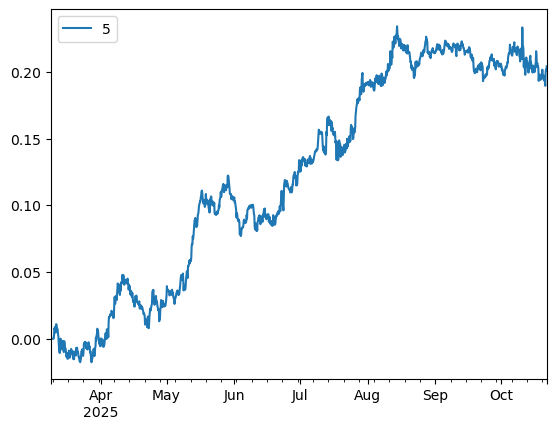

In [30]:
#KURTOSIS STRATEGY
strats_lag3 = {}#Use this for comparing sharpe values of time horizons
for hor in [5]:
    avg_ret = ret.rolling(hor,min_periods=1).kurt().rank() #you can change the metric here, for instance vol instead of mean
    avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
    strats_lag3[hor] = (-avg_ret.shift(5)*ret).sum(1) #Reversal
    print(-avg_ret.shift(5))
strats_lag3 = pd.DataFrame(strats_lag3)
to = (strats_lag3.fillna(0) - strats_lag3.shift().fillna(0)).abs()
 #ret will be replaced with whatever strategy we are using
tcost_bps = 20 # (comissions + slip)
T_cost_tot=pd.DataFrame(to*tcost_bps*1e-4)
strats_lag3=strats_lag3-T_cost_tot
print(strats_lag3.mean()*np.sqrt(252*6)/strats_lag3.std()) # first signal spotted, a reversal)
print(strats_lag3.corr())
strats_lag3.cumsum().plot()

0.9015628570929264 0.09843714290707366
17.149668008669618
0.07584276194154084
max drawdown -0.04598771891388417
Drawdown durations: [1, 1, 1, 3, 1, 1, 18, 1, 3, 1, 2, 2, 3, 1, 1, 5, 1, 5, 4, 1, 2, 6, 7, 2, 1, 3, 12, 6, 1, 7, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 10, 25, 2, 1, 1, 1, 1, 3, 1, 11, 6, 24, 1, 2, 2, 2, 2, 1, 1, 12, 3, 5, 2, 1, 1, 1, 1, 1, 7, 1, 2, 8, 2, 2, 2, 5, 5, 21, 2, 1, 1, 2, 2, 1, 7, 4, 2, 4, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 19, 13, 7, 10, 1, 1, 1, 5, 1, 3, 4, 3, 3, 1, 2, 4, 2, 13, 1, 9, 6, 2, 1, 1, 4, 1, 4, 1, 3, 5, 1, 2, 3, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 6, 1, 1, 3, 7, 2, 1, 1, 16, 2, 13, 3, 1, 1, 1, 1, 7, 1, 5, 4, 3, 2, 8, 7, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]
Longest drawdown: 4.166666666666667 days
Percentage of time in drawdown: 46.88%
Expected Return: 0.001950465372992867
Standard Deviation of Return: 0.0044224040898751095
Horizon 5: alpha = 0.001945, t-stat = 16.316
                       

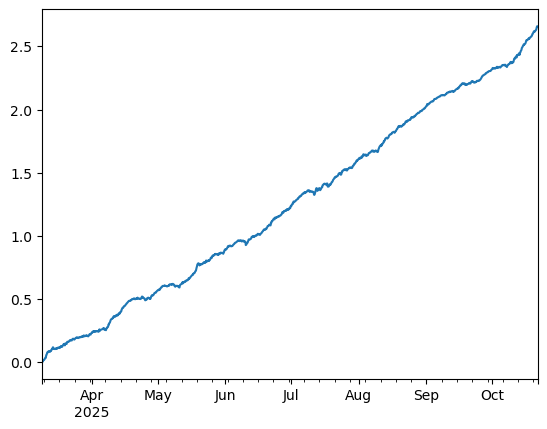

In [31]:
n=252
combo_5 = strats_lag3[5]
SR1 = combo_4.mean()*np.sqrt(n*6)/combo_4.std()
SR2 = combo_5.mean()*np.sqrt(n*6)/combo_5.std()
tot = SR1+SR2
w1 =  SR1/tot
w2 = SR2/tot
print(w1,w2)
combo_5 = w1*combo_4+w2*combo_5 #long 8 hour rolling average vol and short 24 hour rolling average VOL lagged 16 hours
print(combo_5.mean()*np.sqrt(n*6)/combo_5.std()) # first signal spotted, a reversal)
print(combo_5.mean()*np.sqrt(n*6))
print('max drawdown',max_drawdown(combo_5))
durations, max_dd_time = drawdown_durations(combo_5.cumsum())
print(f"Drawdown durations: {durations}")
print(f"Longest drawdown: {max_dd_time/6} days")
pct_drawdown = percent_time_in_drawdown(combo_5.cumsum())
print(f"Percentage of time in drawdown: {pct_drawdown:.2f}%")
combo_5.cumsum().plot()
print('Expected Return:',combo_5.mean())
print('Standard Deviation of Return:',combo_5.std())
# Build regression inputs
X = sm.add_constant(ret.iloc[:, :])  # Benchmark BTC with intercept 
df = pd.concat([combo_5, X], axis=1)
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

# Re-split cleaned data
y_clean = df_clean.iloc[:, 0]  # Strategy returns
X_clean = df_clean.iloc[:, 1:]  # Benchmark + intercept

# Run regression
model = sm.OLS(y_clean, X_clean).fit()
alpha_t_stat = model.tvalues['const']
alpha = model.params['const']
print(f"Horizon {hor}: alpha = {alpha:.6f}, t-stat = {alpha_t_stat:.3f}")
print(model.summary())

In [32]:
Port=ret